In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_csv('https://raw.githubusercontent.com/Jeisianyf/power-sum-method/main/dados.csv')

# 1)

In [ ]:
barras_fim_linha = data[~data['para'].isin(data['de'])]
barras_fim_linha = np.array(barras_fim_linha['para'])

barras_ramific = []
barras_ramific_num = []

from collections import Counter

c = Counter(data['de'])

for numero, repeticoes in c.items():
    if repeticoes > 1:
       barras_ramific.append([indice for indice, item in enumerate(data['de']) if item == numero])
       barras_ramific_num.append(numero)

num_inter = 10
inter = 0

carga = 1

barras = np.unique(np.concatenate((data['de'], data['para']), axis=0))
nBarras = len(barras)

perdas_P = np.zeros(len(data))
perdas_Q = np.zeros(len(data))

P_inst = np.zeros(len(data))
Q_inst = np.zeros(len(data))


P = np.zeros(len(data)) #Fluxo de Potência
Q = np.zeros(len(data)) #Fluxo de Potência

dif_P = P - perdas_P
dif_Q = Q - perdas_Q

R = np.zeros(len(data))
X = np.zeros(len(data))

A = np.zeros(len(data))
B = np.zeros(len(data))
C = np.zeros(len(data))

U = np.zeros(nBarras)
U[0] = data['vi'][0]*1000

#Calculando Potência Instalada e R e X de Cada Trecho 0-1...
for i, row in data[::-1].iterrows():
  P_inst[i] = ((row['Sinst']*carga*row['fp'])*1000)
  Q_inst[i] = ((row['Sinst']*carga*(np.sin(np.arccos(row['fp']))))*1000)

  R[i] = row['r']*row['dist']
  X[i] = row['x']*row['dist']


def power_flow(data, P_inst, Q_inst, perdas_P, perdas_Q, P, Q): #Fluxo de Potência
  for i in range((len(data)-1),-1,-1): #Passo 2
    if barras[i+1] not in barras_fim_linha :
      P[i] = (P_inst[i] + P[i+1] + perdas_P[i] + perdas_P[i+1])
      Q[i] = (Q_inst[i] + Q[i+1] + perdas_Q[i] + perdas_Q[i+1])

      if barras[i+1] in barras_ramific_num:
        for j in range(len(barras_ramific[0])):
          P[i] = P[i+1] + P[barras_ramific[barras_ramific_num.index(barras[i+1])][j]]
          Q[i] = Q[i+1] + Q[barras_ramific[barras_ramific_num.index(barras[i+1])][j]]
    else:
      P[i] = (P_inst[i] + perdas_P[i])
      Q[i] = (Q_inst[i] + perdas_Q[i])

  return P, Q

def calculate_U(R, X, P, Q, U, data, nBarras): #Tensão nas Barras e Perdas
  for i in range(1,(nBarras)):
    A = R[i-1]*(P[i-1]-perdas_P[i-1]) + (X[i-1]*(Q[i-1]-perdas_Q[i-1])) - 0.5*((U[data['de']][i-1])**2)
    C = ((R[i-1]**2)+(X[i-1]**2))*(((P[i-1]**2)-perdas_P[i-1])+((Q[i-1]**2)-perdas_Q[i-1]))
    B = np.sqrt(np.abs((A**2)-C))
    U[i] = np.sqrt(np.abs(B-A))

  return U

def calculate_losses(R, X, P, Q, U, data, nBarras):
  for i in range((len(data))):
    perdas_P[i] = R[i]*((((dif_P[i])**2)+((dif_Q[i])**2))/(U[data['de']][i])**2)
    perdas_Q[i] = X[i]*((((dif_P[i])**2)+((dif_Q[i])**2))/(U[data['de']][i])**2)
  return perdas_P, perdas_Q


while inter != num_inter:
  P, Q = power_flow(data, P_inst, Q_inst, perdas_P, perdas_Q, P, Q)
  U = calculate_U(R, X, P, Q, U, data, nBarras)
  dif_P = P
  dif_Q = Q
  perdas_P, perdas_Q = calculate_losses(R, X, P, Q, U, data, nBarras)
  inter += 1

  print(f'Interação: {inter}')
  print(f'Fluxo de Potência (P): {P}')
  print(f'Fluxo de Potência (Q): {Q}')
  print(f'Tensão nas Barras: {U}')
  print(f'Perdas nos Trechos (P): {perdas_P}')
  print(f'Perdas nos Trechos (Q): {perdas_Q}')
  print('-------------------------------------')

Interação: 1
Fluxo de Potência (P): [3798853.5  3607603.5  3403714.5  3212464.5  3021214.5  1013123.25
  823628.25  632378.25  441128.25  287156.25   95906.25  203889.
  140296.5    76704.     13111.5  2008091.25 1816841.25 1625591.25
 1434341.25 1243091.25 1051841.25  860591.25  669341.25  478091.25
  286841.25   95591.25  189495.    126330.     63165.    153972.
  115479.     76986.     38493.  ]
Fluxo de Potência (Q): [2355659.71594918 2237133.61122959 2110562.27737915 1992036.17265956
 1873510.06793997  628931.54504389  507619.36521432  389093.26049473
  270567.15577514  177332.91734311   58806.81262352  126571.33385044
   86809.61930302   47047.90475561    7286.1902082  1244578.52289608
 1126052.41817649 1007526.31345689  889000.2087373   770474.10401771
  651947.99929811  533421.89457852  414895.78985893  296369.68513933
  177843.58041974   59317.47570015  121312.17982956   80874.78655304
   40437.39327652   93234.23843203   69925.67882402   46617.11921601
   23308.55960801]
Tens

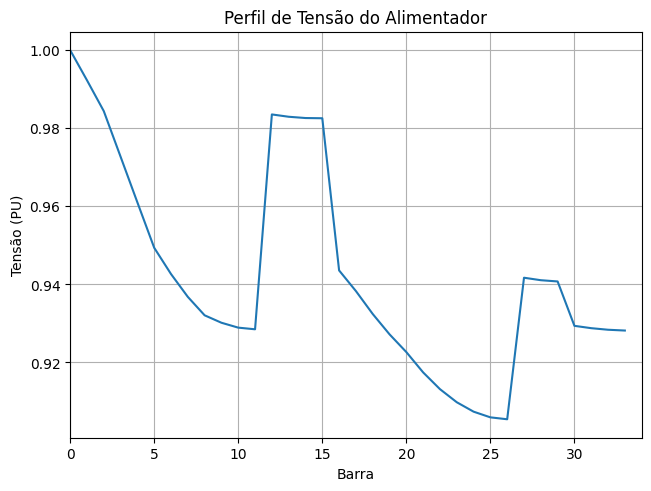

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(layout='constrained')


ax.plot(barras, U/U[0])

ax.set_xlabel('Barra')
ax.set_ylabel('Tensão (PU)')
ax.set_title('Perfil de Tensão do Alimentador')
plt.grid(True)

ax.set_xlim(0, len(barras))
plt.show()

# 2)

In [ ]:
 barras = np.unique(np.concatenate((data['de'], data['para']), axis=0))

In [ ]:
def sum_of_powers_method(data, num_inter, carga):

  barras_fim_linha = data[~data['para'].isin(data['de'])]
  barras_fim_linha = np.array(barras_fim_linha['para'])

  barras_ramific = []
  barras_ramific_num = []

  from collections import Counter

  c = Counter(data['de'])

  for numero, repeticoes in c.items():
      if repeticoes > 1:
        barras_ramific.append([indice for indice, item in enumerate(data['de']) if item == numero])
        barras_ramific_num.append(numero)

  inter = 0

  barras = np.unique(np.concatenate((data['de'], data['para']), axis=0))
  nBarras = len(barras)

  perdas_P = np.zeros(len(data))
  perdas_Q = np.zeros(len(data))

  P_inst = np.zeros(len(data))
  Q_inst = np.zeros(len(data))


  P = np.zeros(len(data)) #Fluxo de Potência
  Q = np.zeros(len(data)) #Fluxo de Potência

  dif_P = P - perdas_P
  dif_Q = Q - perdas_Q

  R = np.zeros(len(data))
  X = np.zeros(len(data))

  A = np.zeros(len(data))
  B = np.zeros(len(data))
  C = np.zeros(len(data))

  U = np.zeros(nBarras)
  U[0] = data['vi'][0]*1000

  #Calculando Potência Instalada e R e X de Cada Trecho 0-1...
  for i, row in data[::-1].iterrows():
    P_inst[i] = ((row['Sinst']*carga*row['fp'])*1000)
    Q_inst[i] = ((row['Sinst']*carga*(np.sin(np.arccos(row['fp']))))*1000)

    R[i] = row['r']*row['dist']
    X[i] = row['x']*row['dist']


  def power_flow(data, P_inst, Q_inst, perdas_P, perdas_Q, P, Q): #Fluxo de Potência
    for i in range((len(data)-1),-1,-1): #Passo 2
      if barras[i+1] not in barras_fim_linha :
        P[i] = (P_inst[i] + P[i+1] + perdas_P[i] + perdas_P[i+1])
        Q[i] = (Q_inst[i] + Q[i+1] + perdas_Q[i] + perdas_Q[i+1])

        if barras[i+1] in barras_ramific_num:
          for j in range(len(barras_ramific[0])):
            P[i] = P[i+1] + P[barras_ramific[barras_ramific_num.index(barras[i+1])][j]]
            Q[i] = Q[i+1] + Q[barras_ramific[barras_ramific_num.index(barras[i+1])][j]]
      else:
        P[i] = (P_inst[i] + perdas_P[i])
        Q[i] = (Q_inst[i] + perdas_Q[i])

    return P, Q

  def calculate_U(R, X, P, Q, U, data, nBarras): #Tensão nas Barras e Perdas
    for i in range(1,(nBarras)):
      A = R[i-1]*(P[i-1]-perdas_P[i-1]) + (X[i-1]*(Q[i-1]-perdas_Q[i-1])) - 0.5*((U[data['de']][i-1])**2)
      C = ((R[i-1]**2)+(X[i-1]**2))*(((P[i-1]**2)-perdas_P[i-1])+((Q[i-1]**2)-perdas_Q[i-1]))
      B = np.sqrt(np.abs((A**2)-C))
      U[i] = np.sqrt(np.abs(B-A))

    return U

  def calculate_losses(R, X, P, Q, U, data, nBarras):
    for i in range((len(data))):
      perdas_P[i] = R[i]*((((dif_P[i])**2)+((dif_Q[i])**2))/(U[data['de']][i])**2)
      perdas_Q[i] = X[i]*((((dif_P[i])**2)+((dif_Q[i])**2))/(U[data['de']][i])**2)
    return perdas_P, perdas_Q


  while inter != num_inter:
    P, Q = power_flow(data, P_inst, Q_inst, perdas_P, perdas_Q, P, Q)
    U = calculate_U(R, X, P, Q, U, data, nBarras)
    dif_P = P
    dif_Q = Q
    perdas_P, perdas_Q = calculate_losses(R, X, P, Q, U, data, nBarras)
    inter += 1

    print(f'Interação: {inter}')
    print(f'Fluxo de Potência (P): {P}')
    print(f'Fluxo de Potência (Q): {Q}')
    print(f'Tensão nas Barras: {U}')
    print(f'Perdas nos Trechos (P): {perdas_P}')
    print(f'Perdas nos Trechos (Q): {perdas_Q}')
    print('-------------------------------------')

  return P, Q, U, perdas_P, perdas_Q


In [ ]:
carga_leve = sum_of_powers_method(data, 1, 0.5)
V_carga_leve= carga_leve[2]

Interação: 1
Fluxo de Potência (P): [1899426.75  1803801.75  1701857.25  1606232.25  1510607.25   506561.625
  411814.125  316189.125  220564.125  143578.125   47953.125  101944.5
   70148.25    38352.       6555.75  1004045.625  908420.625  812795.625
  717170.625  621545.625  525920.625  430295.625  334670.625  239045.625
  143420.625   47795.625   94747.5     63165.      31582.5     76986.
   57739.5     38493.      19246.5  ]
Fluxo de Potência (Q): [1177829.85797459 1118566.80561479 1055281.13868958  996018.08632978
  936755.03396998  314465.77252194  253809.68260716  194546.63024737
  135283.57788757   88666.45867156   29403.40631176   63285.66692522
   43404.80965151   23523.9523778     3643.0951041   622289.26144804
  563026.20908824  503763.15672845  444500.10436865  385237.05200885
  325973.99964906  266710.94728926  207447.89492946  148184.84256967
   88921.79020987   29658.73785007   60656.08991478   40437.39327652
   20218.69663826   46617.11921601   34962.83941201   23308.

In [ ]:
carga_med = sum_of_powers_method(data, 10, 0.9)
V_carga_med= carga_med[2]

Interação: 1
Fluxo de Potência (P): [3418968.15  3246843.15  3063343.05  2891218.05  2719093.05   911810.925
  741265.425  569140.425  397015.425  258440.625   86315.625  183500.1
  126266.85    69033.6     11800.35  1807282.125 1635157.125 1463032.125
 1290907.125 1118782.125  946657.125  774532.125  602407.125  430282.125
  258157.125   86032.125  170545.5    113697.      56848.5    138574.8
  103931.1     69287.4     34643.7  ]
Fluxo de Potência (Q): [2120093.74435426 2013420.25010663 1899506.04964124 1792832.5553936
 1686159.06114597  566038.3905395   456857.42869289  350183.93444526
  243510.44019762  159599.6256088    52926.13136117  113914.20046539
   78128.65737272   42343.11428005    6557.57118738 1120120.67060647
 1013447.17635884  906773.6821112   800100.18786357  693426.69361594
  586753.1993683   480079.70512067  373406.21087303  266732.7166254
  160059.22237777   53385.72813013  109180.96184661   72787.30789774
   36393.65394887   83910.81458882   62933.11094162   41955.4

In [ ]:
carga_pesada = sum_of_powers_method(data, 10, 1.2)
V_carga_pesada= carga_pesada[2]

Interação: 1
Fluxo de Potência (P): [4558624.2 4329124.2 4084457.4 3854957.4 3625457.4 1215747.9  988353.9
  758853.9  529353.9  344587.5  115087.5  244666.8  168355.8   92044.8
   15733.8 2409709.5 2180209.5 1950709.5 1721209.5 1491709.5 1262209.5
 1032709.5  803209.5  573709.5  344209.5  114709.5  227394.   151596.
   75798.   184766.4  138574.8   92383.2   46191.6]
Fluxo de Potência (Q): [2826791.65913902 2684560.33347551 2532674.73285498 2390443.40719147
 2248212.08152796  754717.85405266  609143.23825719  466911.91259368
  324680.58693016  212799.50081173   70568.17514822  151885.60062052
  104171.54316363   56457.48570673    8743.42824983 1493494.2274753
 1351262.90181178 1209031.57614827 1066800.25048476  924568.92482125
  782337.59915774  640106.27349422  497874.94783071  355643.6221672
  213412.29650369   71180.97084018  145574.61579547   97049.74386365
   48524.87193182  111881.08611843   83910.81458882   55940.54305922
   27970.27152961]
Tensão nas Barras: [13800.         13

In [ ]:
Vbase = 13.8E3

V_carga_leve = V_carga_leve/Vbase
V_carga_med = V_carga_med/Vbase
V_carga_pesada = V_carga_pesada/Vbase

In [ ]:
V_carga_pesada

array([1.        , 0.99228856, 0.98438616, 0.97270356, 0.96099963,
       0.94938109, 0.94265149, 0.93680351, 0.93208036, 0.93017646,
       0.92892275, 0.92850053, 0.98352908, 0.98293444, 0.98260679,
       0.9825508 , 0.94357895, 0.93828974, 0.93242296, 0.92721178,
       0.92266315, 0.91745645, 0.91317101, 0.90981647, 0.9074038 ,
       0.90594548, 0.90545558, 0.9417062 , 0.94107125, 0.94075135,
       0.92938391, 0.92878513, 0.92838298, 0.9281804 ])

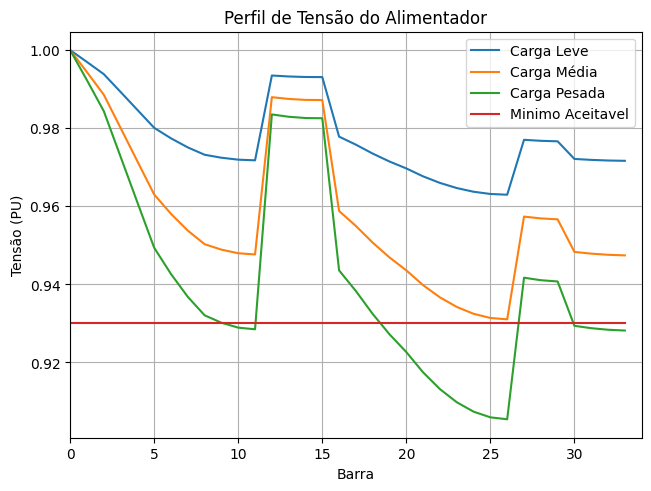

In [ ]:
fig, ax = plt.subplots(layout='constrained')

limite = np.ones(len(barras))*0.93

ax.plot(barras, V_carga_leve, label='Carga Leve')
ax.plot(barras, V_carga_med, label='Carga Média')
ax.plot(barras, V_carga_pesada, label='Carga Pesada')
ax.plot(barras, limite, label='Minimo Aceitavel')

ax.set_xlabel('Barra')
ax.set_ylabel('Tensão (PU)')
ax.set_title('Perfil de Tensão do Alimentador')
ax.legend()
plt.grid(True)

ax.set_xlim(0, len(barras))
plt.show()

# 3)

In [ ]:
def sum_of_powers_method(data, num_inter, carga):

  barras_fim_linha = data[~data['para'].isin(data['de'])]
  barras_fim_linha = np.array(barras_fim_linha['para'])

  barras_ramific = []
  barras_ramific_num = []

  from collections import Counter

  c = Counter(data['de'])

  for numero, repeticoes in c.items():
      if repeticoes > 1:
        barras_ramific.append([indice for indice, item in enumerate(data['de']) if item == numero])
        barras_ramific_num.append(numero)

  inter = 0

  barras = np.unique(np.concatenate((data['de'], data['para']), axis=0))
  nBarras = len(barras)

  perdas_P = np.zeros(len(data))
  perdas_Q = np.zeros(len(data))

  P_inst = np.zeros(len(data))
  Q_inst = np.zeros(len(data))

  Q_banco_capacitores = np.zeros(len(data)) #Potência reativa dos bancos de capacitores
  Q_banco_capacitores[23] = Q_banco_capacitores[24] = Q_banco_capacitores[25] = Q_banco_capacitores[26] = 300000

  P = np.zeros(len(data)) #Fluxo de Potência
  Q = np.zeros(len(data)) #Fluxo de Potência

  dif_P = P - perdas_P
  dif_Q = Q - perdas_Q

  R = np.zeros(len(data))
  X = np.zeros(len(data))

  A = np.zeros(len(data))
  B = np.zeros(len(data))
  C = np.zeros(len(data))

  U = np.zeros(nBarras)
  U[0] = data['vi'][0]*1000

  #Calculando Potência Instalada e R e X de Cada Trecho 0-1...
  for i, row in data[::-1].iterrows():
    P_inst[i] = ((row['Sinst']*carga*row['fp'])*1000)
    Q_inst[i] = ((row['Sinst']*carga*(np.sin(np.arccos(row['fp']))))*1000)

    R[i] = row['r']*row['dist']
    X[i] = row['x']*row['dist']


  def power_flow(data, P_inst, Q_inst, perdas_P, perdas_Q, P, Q): #Fluxo de Potência
    for i in range((len(data)-1),-1,-1): #Passo 2
      if barras[i+1] not in barras_fim_linha :
        P[i] = (P_inst[i] + P[i+1] + perdas_P[i] + perdas_P[i+1])
        Q[i] = (Q_inst[i] + Q[i+1] + perdas_Q[i] + perdas_Q[i+1])

        if barras[i+1] in barras_ramific_num:
          for j in range(len(barras_ramific[0])):
            P[i] = P[i+1] + P[barras_ramific[barras_ramific_num.index(barras[i+1])][j]]
            Q[i] = Q[i+1] + Q[barras_ramific[barras_ramific_num.index(barras[i+1])][j]]
      else:
        P[i] = (P_inst[i] + perdas_P[i])
        Q[i] = (Q_inst[i] + perdas_Q[i])
      Q[i] -= Q_banco_capacitores[i] #Adicionando os bancos de capacitores

    return P, Q

  def calculate_U(R, X, P, Q, U, data, nBarras): #Tensão nas Barras e Perdas
    for i in range(1,(nBarras)):
      A = R[i-1]*(P[i-1]-perdas_P[i-1]) + (X[i-1]*(Q[i-1]-perdas_Q[i-1])) - 0.5*((U[data['de']][i-1])**2)
      C = ((R[i-1]**2)+(X[i-1]**2))*(((P[i-1]**2)-perdas_P[i-1])+((Q[i-1]**2)-perdas_Q[i-1]))
      B = np.sqrt(np.abs((A**2)-C))
      U[i] = np.sqrt(np.abs(B-A))

    return U

  def calculate_losses(R, X, P, Q, U, data, nBarras):
    for i in range((len(data))):
      perdas_P[i] = R[i]*((((dif_P[i])**2)+((dif_Q[i])**2))/(U[data['de']][i])**2)
      perdas_Q[i] = X[i]*((((dif_P[i])**2)+((dif_Q[i])**2))/(U[data['de']][i])**2)
    return perdas_P, perdas_Q


  while inter != num_inter:
    P, Q = power_flow(data, P_inst, Q_inst, perdas_P, perdas_Q, P, Q)
    U = calculate_U(R, X, P, Q, U, data, nBarras)
    dif_P = P
    dif_Q = Q
    perdas_P, perdas_Q = calculate_losses(R, X, P, Q, U, data, nBarras)
    inter += 1

    print(f'Interação: {inter}')
    print(f'Fluxo de Potência (P): {P}')
    print(f'Fluxo de Potência (Q): {Q}')
    print(f'Tensão nas Barras: {U}')
    print(f'Perdas nos Trechos (P): {perdas_P}')
    print(f'Perdas nos Trechos (Q): {perdas_Q}')
    print('-------------------------------------')

  return P, Q, U, perdas_P, perdas_Q


In [ ]:
carga_pesada = sum_of_powers_method(data, 10, 1.2)
V_carga_pesada= carga_pesada[2]

Interação: 1
Fluxo de Potência (P): [4558624.2 4329124.2 4084457.4 3854957.4 3625457.4 1215747.9  988353.9
  758853.9  529353.9  344587.5  115087.5  244666.8  168355.8   92044.8
   15733.8 2409709.5 2180209.5 1950709.5 1721209.5 1491709.5 1262209.5
 1032709.5  803209.5  573709.5  344209.5  114709.5  227394.   151596.
   75798.   184766.4  138574.8   92383.2   46191.6]
Fluxo de Potência (Q): [1626791.65913902 1484560.33347551 1332674.73285498 1190443.40719147
 1048212.08152796  454717.85405266  609143.23825719  466911.91259368
  324680.58693016  212799.50081173   70568.17514822  151885.60062052
  104171.54316363   56457.48570673    8743.42824983  593494.2274753
  451262.90181178  309031.57614827  166800.25048476   24568.92482125
 -117662.40084226 -259893.72650578 -402125.05216929 -544356.3778328
 -386587.70349631 -228819.02915982 -154425.38420453   97049.74386365
   48524.87193182  111881.08611843   83910.81458882   55940.54305922
   27970.27152961]
Tensão nas Barras: [13800.         13

In [ ]:
Vbase = 13.8E3

V_carga_pesada = V_carga_pesada/Vbase

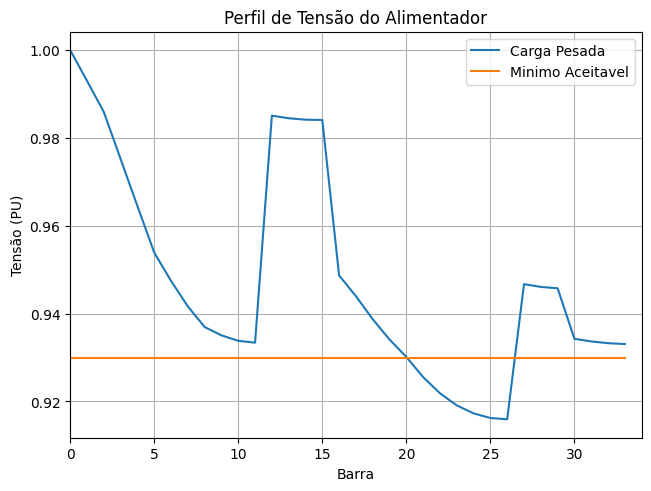

In [ ]:
fig, ax = plt.subplots(layout='constrained')

limite = np.ones(len(barras))*0.93

ax.plot(barras, V_carga_pesada, label='Carga Pesada')
ax.plot(barras, limite, label='Minimo Aceitavel')

ax.set_xlabel('Barra')
ax.set_ylabel('Tensão (PU)')
ax.set_title('Perfil de Tensão do Alimentador')
ax.legend()
plt.grid(True)

ax.set_xlim(0, len(barras))
plt.show()

EXTRAPOLANDO OS VALORES E QUANTIDADES DE BANCOS DE CAPACITORES PARA DE FATO MELHORAR O PERFIL DE TENSÃO DO ALIMENTADOR

In [ ]:
def sum_of_powers_method(data, num_inter, carga):

  barras_fim_linha = data[~data['para'].isin(data['de'])]
  barras_fim_linha = np.array(barras_fim_linha['para'])

  barras_ramific = []
  barras_ramific_num = []

  from collections import Counter

  c = Counter(data['de'])

  for numero, repeticoes in c.items():
      if repeticoes > 1:
        barras_ramific.append([indice for indice, item in enumerate(data['de']) if item == numero])
        barras_ramific_num.append(numero)

  inter = 0

  barras = np.unique(np.concatenate((data['de'], data['para']), axis=0))
  nBarras = len(barras)

  perdas_P = np.zeros(len(data))
  perdas_Q = np.zeros(len(data))

  P_inst = np.zeros(len(data))
  Q_inst = np.zeros(len(data))

  Q_banco_capacitores = np.zeros(len(data)) #Potência reativa dos bancos de capacitores
  Q_banco_capacitores[20] = Q_banco_capacitores[21] = Q_banco_capacitores[22] = Q_banco_capacitores[23] = Q_banco_capacitores[24] = Q_banco_capacitores[25] = Q_banco_capacitores[26] = 600000

  P = np.zeros(len(data)) #Fluxo de Potência
  Q = np.zeros(len(data)) #Fluxo de Potência

  dif_P = P - perdas_P
  dif_Q = Q - perdas_Q

  R = np.zeros(len(data))
  X = np.zeros(len(data))

  A = np.zeros(len(data))
  B = np.zeros(len(data))
  C = np.zeros(len(data))

  U = np.zeros(nBarras)
  U[0] = data['vi'][0]*1000

  #Calculando Potência Instalada e R e X de Cada Trecho 0-1...
  for i, row in data[::-1].iterrows():
    P_inst[i] = ((row['Sinst']*carga*row['fp'])*1000)
    Q_inst[i] = ((row['Sinst']*carga*(np.sin(np.arccos(row['fp']))))*1000)

    R[i] = row['r']*row['dist']
    X[i] = row['x']*row['dist']


  def power_flow(data, P_inst, Q_inst, perdas_P, perdas_Q, P, Q): #Fluxo de Potência
    for i in range((len(data)-1),-1,-1): #Passo 2
      if barras[i+1] not in barras_fim_linha :
        P[i] = (P_inst[i] + P[i+1] + perdas_P[i] + perdas_P[i+1])
        Q[i] = (Q_inst[i] + Q[i+1] + perdas_Q[i] + perdas_Q[i+1])

        if barras[i+1] in barras_ramific_num:
          for j in range(len(barras_ramific[0])):
            P[i] = P[i+1] + P[barras_ramific[barras_ramific_num.index(barras[i+1])][j]]
            Q[i] = Q[i+1] + Q[barras_ramific[barras_ramific_num.index(barras[i+1])][j]]
      else:
        P[i] = (P_inst[i] + perdas_P[i])
        Q[i] = (Q_inst[i] + perdas_Q[i])
      Q[i] -= Q_banco_capacitores[i] #Adicionando os bancos de capacitores

    return P, Q

  def calculate_U(R, X, P, Q, U, data, nBarras): #Tensão nas Barras e Perdas
    for i in range(1,(nBarras)):
      A = R[i-1]*(P[i-1]-perdas_P[i-1]) + (X[i-1]*(Q[i-1]-perdas_Q[i-1])) - 0.5*((U[data['de']][i-1])**2)
      C = ((R[i-1]**2)+(X[i-1]**2))*(((P[i-1]**2)-perdas_P[i-1])+((Q[i-1]**2)-perdas_Q[i-1]))
      B = np.sqrt(np.abs((A**2)-C))
      U[i] = np.sqrt(np.abs(B-A))

    return U

  def calculate_losses(R, X, P, Q, U, data, nBarras):
    for i in range((len(data))):
      perdas_P[i] = R[i]*((((dif_P[i])**2)+((dif_Q[i])**2))/(U[data['de']][i])**2)
      perdas_Q[i] = X[i]*((((dif_P[i])**2)+((dif_Q[i])**2))/(U[data['de']][i])**2)
    return perdas_P, perdas_Q


  while inter != num_inter:
    P, Q = power_flow(data, P_inst, Q_inst, perdas_P, perdas_Q, P, Q)
    U = calculate_U(R, X, P, Q, U, data, nBarras)
    dif_P = P
    dif_Q = Q
    perdas_P, perdas_Q = calculate_losses(R, X, P, Q, U, data, nBarras)
    inter += 1

    print(f'Interação: {inter}')
    print(f'Fluxo de Potência (P): {P}')
    print(f'Fluxo de Potência (Q): {Q}')
    print(f'Tensão nas Barras: {U}')
    print(f'Perdas nos Trechos (P): {perdas_P}')
    print(f'Perdas nos Trechos (Q): {perdas_Q}')
    print('-------------------------------------')

  return P, Q, U, perdas_P, perdas_Q

In [ ]:
carga_pesada = sum_of_powers_method(data, 10, 1.2)
V_carga_pesada= carga_pesada[2]

Interação: 1
Fluxo de Potência (P): [4558624.2 4329124.2 4084457.4 3854957.4 3625457.4 1215747.9  988353.9
  758853.9  529353.9  344587.5  115087.5  244666.8  168355.8   92044.8
   15733.8 2409709.5 2180209.5 1950709.5 1721209.5 1491709.5 1262209.5
 1032709.5  803209.5  573709.5  344209.5  114709.5  227394.   151596.
   75798.   184766.4  138574.8   92383.2   46191.6]
Fluxo de Potência (Q): [-1373208.34086098 -1515439.66652449 -1667325.26714502 -1809556.59280853
 -1951787.91847204   154717.85405266   609143.23825719   466911.91259368
   324680.58693016   212799.50081173    70568.17514822   151885.60062052
   104171.54316363    56457.48570673     8743.42824983 -2106505.7725247
 -2248737.09818822 -2390968.42385173 -2533199.74951524 -2675431.07517875
 -2817662.40084226 -2359893.72650578 -1902125.05216929 -1444356.3778328
  -986587.70349631  -528819.02915982  -454425.38420453    97049.74386365
    48524.87193182   111881.08611843    83910.81458882    55940.54305922
    27970.27152961]
Tens

In [ ]:
Vbase = 13.8E3

V_carga_pesada = V_carga_pesada/Vbase

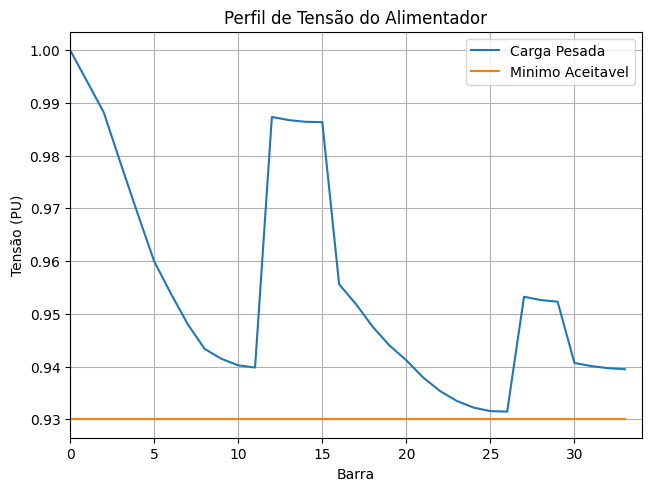

In [ ]:
fig, ax = plt.subplots(layout='constrained')

limite = np.ones(len(barras))*0.93

ax.plot(barras, V_carga_pesada, label='Carga Pesada')
ax.plot(barras, limite, label='Minimo Aceitavel')

ax.set_xlabel('Barra')
ax.set_ylabel('Tensão (PU)')
ax.set_title('Perfil de Tensão do Alimentador')
ax.legend()
plt.grid(True)

ax.set_xlim(0, len(barras))
plt.show()